<a href="https://colab.research.google.com/github/donw385/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-2-validate-classification-problems/LS_DS_242_Validate_classification_problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Model Validation_ 

# Validate classification problems

Objectives
- Imbalanced Classes
- Confusion Matrix
- ROC AUC


Reading
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/)
- [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)

## Preliminary

We'll use [mlxtend](http://rasbt.github.io/mlxtend/) and [yellowbrick](http://www.scikit-yb.org/en/latest/) for visualizations. These libraries are already installed on Google Colab. But if you are running locally with Anaconda Python, you'll probably need to install them:

```
conda install -c conda-forge mlxtend 
conda install -c districtdatalabs yellowbrick
```

We'll reuse the `train_validation_test_split` function from yesterday's lesson.

In [4]:
!pip install category_encoders


    100% |████████████████████████████████| 61kB 4.0MB/s 


In [0]:
import pandas as pd
import category_encoders as ce


In [0]:
train_features = pd.read_csv('https://raw.githubusercontent.com/donw385/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_features.csv')
train_labels = pd.read_csv('https://raw.githubusercontent.com/donw385/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/train_labels.csv')
test_features = pd.read_csv('https://raw.githubusercontent.com/donw385/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/test_features.csv')
sample_submission = pd.read_csv('https://raw.githubusercontent.com/donw385/DS-Unit-2-Sprint-4-Model-Validation/master/module-1-begin-modeling-process/bank-marketing/sample_submission.csv')

In [0]:
# Imports
%matplotlib inline
import warnings
import category_encoders as ce
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load data
X_train = train_features.drop(columns='id')
X_test  = test_features.drop(columns='id')
y_train = train_labels['y']
sample_submission = sample_submission

# Make pipeline
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_predict

y_pred_proba = cross_val_predict(pipeline, X_train, y_train, cv=3, n_jobs=-1, 
                                 method='predict_proba')[:, 1]

In [17]:
y_pred_proba >=.2

array([False, False, False, ..., False, False, False])

In [10]:
#threshold lower, precision decreases, recall increases, more predicted positives

threshold = 0.5
y_pred = y_pred_proba >= threshold

print(classification_report(y_train, y_pred))

pd.DataFrame(confusion_matrix(y_train, y_pred), 
             columns=['Predicted Negative', 'Predicted Positive'], 
             index=['Actual Negative', 'Actual Positive'])

              precision    recall  f1-score   support

           0       0.91      0.98      0.95     27411
           1       0.65      0.23      0.34      3480

   micro avg       0.90      0.90      0.90     30891
   macro avg       0.78      0.61      0.64     30891
weighted avg       0.88      0.90      0.88     30891



,Predicted Negative,Predicted Positive
Actual Negative,26990,421
Actual Positive,2690,790


In [21]:
#TODO 
true_negative  = 26990
false_positive = 421
false_negative = 2690
true_positive  = 790

accuracy = (true_negative + true_positive) / (true_negative + false_positive +false_negative + true_positive)

actual_negative = 26990 + 421
actual_positive = 2690 + 790

predicted_negative = 26990+2690
predicted_positive = 421+790

precision = true_positive / predicted_positive 
recall = true_positive / actual_positive
f1 = 2*precision*recall/(precision+recall)
print ('Accuracy:', accuracy,'Precision:', precision,'Recall:', recall, 'f1:',f1)




Accuracy: 0.899291055647276 Precision: 0.652353426919901 Recall: 0.22701149425287356 f1: 0.3368151780004264


Area under the Receiver Operating Characteristic curve: 0.7868824318368706


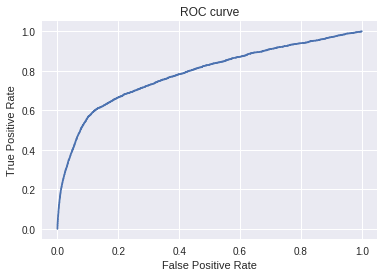

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('Area under the Receiver Operating Characteristic curve:', 
      roc_auc_score(y_train, y_pred_proba))

#when threshold is 0.5
false_positive=421
true_positive=790
false_positive rate

In [0]:
from sklearn.model_selection import train_test_split

def train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, 
    random_state=None, shuffle=True):
        
    assert train_size + val_size + test_size == 1
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=shuffle)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size/(train_size+val_size), 
        random_state=random_state, shuffle=shuffle)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

## Fun demo!

The next code cell does five things:

#### 1. Generate data

We use scikit-learn's [make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function to generate fake data for a binary classification problem, based on several parameters, including:
- Number of samples
- Weights, meaning "the proportions of samples assigned to each class."
- Class separation: "Larger values spread out the clusters/classes and make the classification task easier."

(We are generating fake data so it is easy to visualize.)

#### 2. Split data

We split the data three ways, into train, validation, and test sets. (For this toy example, it's not really necessary to do a three-way split. A two-way split, or even no split, would be ok. But I'm trying to demonstrate good habits, even in toy examples, to avoid confusion.)

#### 3. Fit model

We use scikit-learn to fit a [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) on the training data.

We use this model parameter:

> **class_weight : _dict or ‘balanced’, default: None_**

> Weights associated with classes in the form `{class_label: weight}`. If not given, all classes are supposed to have weight one.

> The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as `n_samples / (n_classes * np.bincount(y))`.


#### 4. Evaluate model

We use our Logistic Regression model, which was fit on the training data, to generate predictions for the validation data.

Then we print [scikit-learn's Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report), with many metrics, and also the accuracy score. We are comparing the correct labels to the Logistic Regression's predicted labels, for the validation set. 

#### 5. Visualize decision function

Based on these examples
- https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/combine/plot_comparison_combine.html
- http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/#example-1-decision-regions-in-2d

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions


#1. Generate data

# Try re-running the cell with different values for these parameters
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8

X, y = make_classification(n_samples=n_samples, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, n_classes=2, 
                           n_clusters_per_class=1, weights=weights, 
                           class_sep=class_sep, random_state=0)


# 2. Split data

# Uses our custom train_validation_test_split function
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, train_size=0.8, val_size=0.1, test_size=0.1, random_state=1)


# 3. Fit model

# Try re-running the cell with different values for this parameter
class_weight = None

model = LogisticRegression(solver='lbfgs', class_weight=class_weight)
model.fit(X_train, y_train)


# 4. Evaluate model

y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))
print('accuracy', accuracy_score(y_val, y_pred))


# 5. Visualize decision regions

plt.figure(figsize=(10, 6))
plot_decision_regions(X_val, y_val, model, legend=0);

Try re-running the cell above with different values for these four parameters:
- `n_samples`
- `weights`
- `class_sep`
- `class_balance`

For example, with a 50% / 50% class distribution:
```
n_samples = 1000
weights = (0.50, 0.50)
class_sep = 0.8
class_balance = None
```

With a 95% / 5% class distribution:
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = None
```

With the same 95% / 5% class distribution, but changing the Logistic Regression's `class_balance` parameter to `'balanced'` (instead of its default `None`)
```
n_samples = 1000
weights = (0.95, 0.05)
class_sep = 0.8
class_balance = 'balanced'
```

With the same 95% / 5% class distribution, but with different values for `class_balance`:
- `{0: 1, 1: 1}` _(equivalent to `None`)_
- `{0: 1, 1: 2}`
- `{0: 1, 1: 10}` _(roughly equivalent to `'balanced'` for this dataset)_
- `{0: 1, 1: 100}`
- `{0: 1, 1: 10000}`

How do the evaluation metrics and decision region plots change?

## What you can do about imbalanced classes

[Learning from Imbalanced Classes](https://www.svds.com/tbt-learning-imbalanced-classes/) gives "a rough outline of useful approaches" : 

- Do nothing. Sometimes you get lucky and nothing needs to be done. You can train on the so-called natural (or stratified) distribution and sometimes it works without need for modification.
- Balance the training set in some way:
  - Oversample the minority class.
  - Undersample the majority class.
  - Synthesize new minority classes.
- Throw away minority examples and switch to an anomaly detection framework.
- At the algorithm level, or after it:
  - Adjust the class weight (misclassification costs).
  - Adjust the decision threshold.
  - Modify an existing algorithm to be more sensitive to rare classes.
- Construct an entirely new algorithm to perform well on imbalanced data.


We demonstrated just one of these options: many scikit-learn classifiers have a `class_balance` parameter, which we can use to "adjust the class weight (misclassification costs)."

The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."

You can see how to "adjust the decision threshold" in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).

## Bank Marketing — getting started

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. 

bank-additional-full.csv with all examples (41188) and 20 inputs, **ordered by date (from May 2008 to November 2010)**

### Download data

In [0]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

In [0]:
!unzip bank-additional.zip

In [0]:
%cd bank-additional

### Load data, assign to X and y

In [0]:
import pandas as pd

bank = pd.read_csv('bank-additional-full.csv', sep=';')

X = bank.drop(columns='y')
y = bank['y'] == 'yes'

### Split data

We want to do "model selection (hyperparameter optimization) and performance estimation" so we'll choose a validation method from the diagram's green box.

There is no one "right" choice here, but I'll choose "3-way holdout method (train/validation/test split)."
  
<img src="https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg" width="600">

Source: https://sebastianraschka.com/blog/2018/model-evaluation-selection-part4.html

There's no one "right" choice here, but I'll choose to split by time, not with a random shuffle, based on this advice by [Rachel Thomas](
https://www.fast.ai/2017/11/13/validation-sets/):
> If your data is a time series, choosing a random subset of the data will be both too easy (you can look at the data both before and after the dates your are trying to predict) and not representative of most business use cases (where you are using historical data to build a model for use in the future).

[According to UCI](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing), this data is "ordered by date (from May 2008 to November 2010)" so if I don't shuffle it when splitting, then it will be split by time.

In [0]:
X_train, X_val, X_test, y_train, y_val, y_test = train_validation_test_split(
    X, y, shuffle=False)

## Bank Marketing — live coding!

# ASSIGNMENT options

Replicate code from the lesson or other examples. [Do it "the hard way" or with the "Benjamin Franklin method."](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit)

Work with one of these datasets
- [Bank Marketing](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing)
- [Synthetic Financial Dataset For Fraud Detection](https://www.kaggle.com/ntnu-testimon/paysim1)
- Any imbalanced binary classification dataset

Continue improving your model. Measure validation performance with a variety of classification metrics, which could include:
- Accuracy
- Precision
- Recall
- F1
- ROC AUC

Try one of the other options mentioned for imbalanced classes
- The [imbalance-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library can be used to "oversample the minority class, undersample the majority class, or synthesize new minority classes."
- You can see how to "adjust the decision threshold" in a great blog post, [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415).